In [471]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [410]:
euro = pd.read_csv('./data/eurovision/cleaned_data.csv')
mino = pd.read_csv("./data/minorities/_eurostat_cleared_data.csv")
popu = pd.read_csv("./data/minorities/_population_data.csv")

In [411]:
THRESHOLDS_CUT = [85, 90, 95] # only top 15%, 10% or 5% edges are counted as significant
# Z_THRESHOLD = 1 # cca 0.933

## Significant minorities

In [412]:
sig_matrix = mino.merge(popu, left_on="citizen_name", right_on="country")
len(sig_matrix["citizen_name"].unique())

47

In [413]:
len(sig_matrix.dropna()) == len(sig_matrix)

True

In [414]:
sig_matrix['percent_pop'] = (sig_matrix['head_count'] / sig_matrix['population']) * 100
sig_matrix.head()

,citizen_name,minority_name,head_count,country,population,percent_pop
0,Albania,Austria,6592.0,Albania,3107100,0.212159
1,Albania,Belgium,3176.0,Albania,3107100,0.102218
2,Albania,Bulgaria,564.0,Albania,3107100,0.018152
3,Albania,Cyprus,388.0,Albania,3107100,0.012488
4,Albania,Czech Republic,688.0,Albania,3107100,0.022143


### Treshhold signinficance

In [415]:
for thr in THRESHOLDS_CUT:
    threshold = np.percentile(sig_matrix["percent_pop"], thr)
    sig_matrix[f'significant_threshold_{thr}'] = sig_matrix['percent_pop'] > threshold

In [416]:
sig_matrix.head()

,citizen_name,minority_name,head_count,country,population,percent_pop,significant_threshold_85,significant_threshold_90,significant_threshold_95
0,Albania,Austria,6592.0,Albania,3107100,0.212159,True,False,False
1,Albania,Belgium,3176.0,Albania,3107100,0.102218,False,False,False
2,Albania,Bulgaria,564.0,Albania,3107100,0.018152,False,False,False
3,Albania,Cyprus,388.0,Albania,3107100,0.012488,False,False,False
4,Albania,Czech Republic,688.0,Albania,3107100,0.022143,False,False,False


In [417]:
for thr in THRESHOLDS_CUT:
    print(sig_matrix[f'significant_threshold_{thr}'].value_counts())

significant_threshold_85
False    1082
True      191
Name: count, dtype: int64
significant_threshold_90
False    1145
True      128
Name: count, dtype: int64
significant_threshold_95
False    1209
True       64
Name: count, dtype: int64


### Visualization

In [418]:
def vizualize(df, title = "Network of European Countries by Minority Percentage"):
    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_edge(row["citizen_name"], row["minority_name"], weight=row["percent_pop"])
    pos = nx.spring_layout(G, seed=1001)
    # edge_labels = nx.get_edge_attributes(G, 'weight')
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title(title)
    plt.axis("off")
    plt.show()

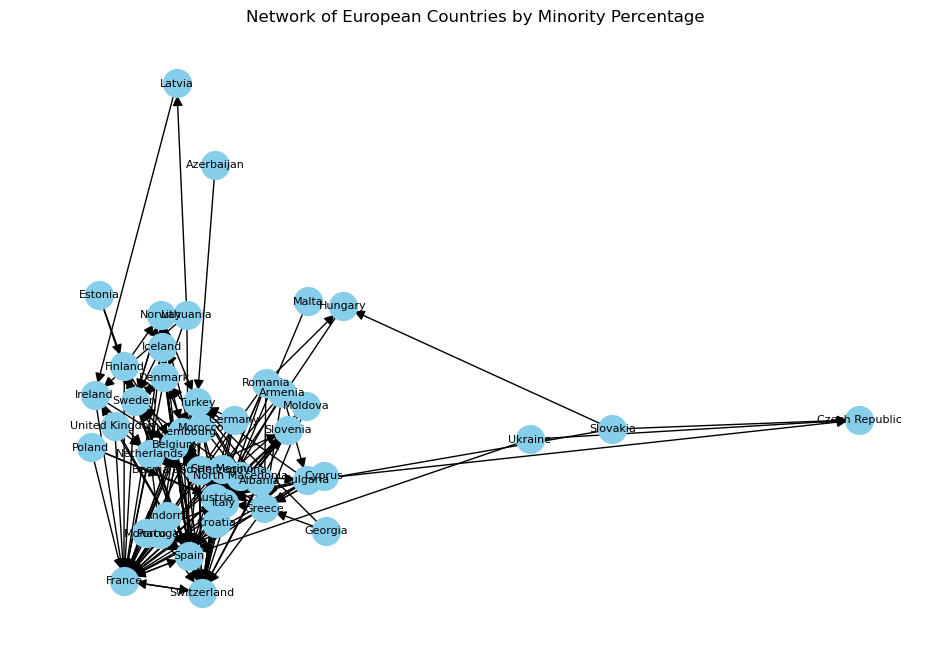

In [419]:
vizualize(sig_matrix[sig_matrix['significant_threshold_85']])

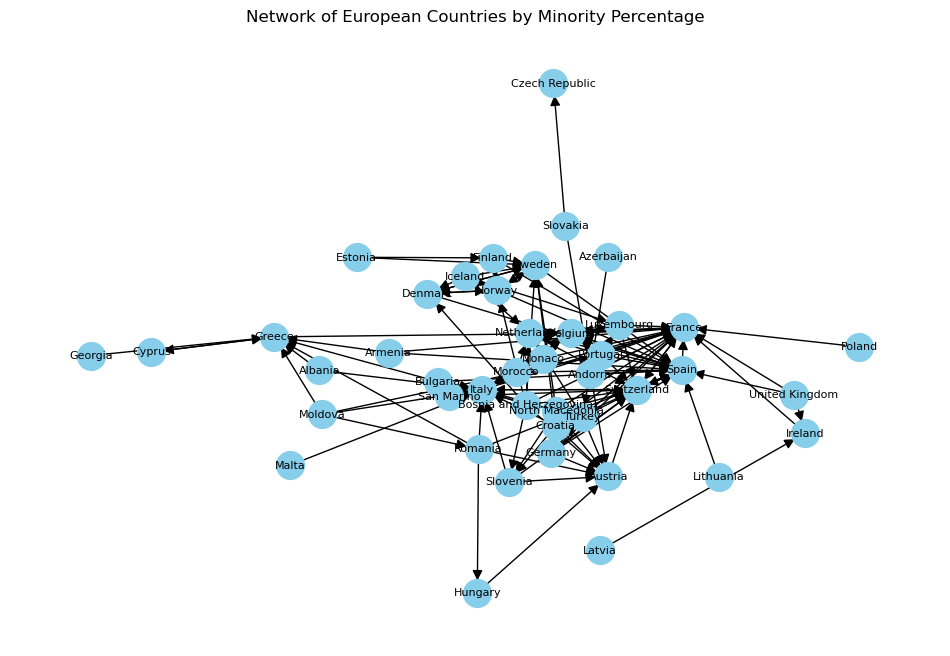

In [420]:
vizualize(sig_matrix[sig_matrix['significant_threshold_90']])

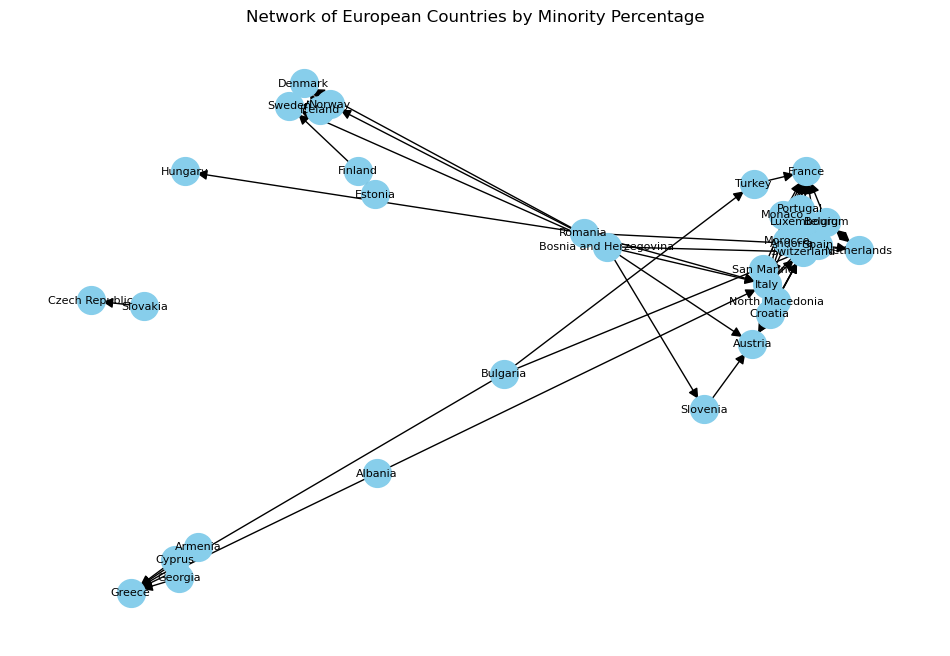

In [421]:
vizualize(sig_matrix[sig_matrix['significant_threshold_95']])

## Significant eurovision voting

In [422]:
euro = euro[euro["year"] > 2008]
euro.head()

,year,from_country,to_country,promil_scale
21595,2009,Albania,Norway,0.075431
21596,2009,Albania,Iceland,0.064655
21597,2009,Albania,Azerbaijan,0.043103
21598,2009,Albania,Turkey,0.107759
21599,2009,Albania,United Kingdom,0.086207


### Avereged

In [427]:
avg = (
    euro[["from_country", "to_country", "promil_scale"]]
    .groupby(["from_country", "to_country"])
    .sum()
    .merge(
        euro[["from_country", "to_country", "year"]].groupby(["from_country", "to_country"]).count(),
        on=["from_country", "to_country"],
    )
    .rename(columns={"promil_scale": "promil_sum", "year": "years_amount"})
    .reset_index()
)
avg

,from_country,to_country,promil_sum,years_amount
0,Albania,Albania,0.000000,8
1,Albania,Armenia,0.141270,9
2,Albania,Australia,0.228021,7
3,Albania,Austria,0.078170,7
4,Albania,Azerbaijan,0.364911,12
...,...,...,...,...
1895,United Kingdom,Sweden,0.797980,13
1896,United Kingdom,Switzerland,0.251600,6
1897,United Kingdom,Turkey,0.264546,3
1898,United Kingdom,Ukraine,0.356676,12


#### Threshold signinficance

In [429]:
avg['standardized'] = avg['promil_sum'] / avg['years_amount']
avg

,from_country,to_country,promil_sum,years_amount,standardized
0,Albania,Albania,0.000000,8,0.000000
1,Albania,Armenia,0.141270,9,0.015697
2,Albania,Australia,0.228021,7,0.032574
3,Albania,Austria,0.078170,7,0.011167
4,Albania,Azerbaijan,0.364911,12,0.030409
...,...,...,...,...,...
1895,United Kingdom,Sweden,0.797980,13,0.061383
1896,United Kingdom,Switzerland,0.251600,6,0.041933
1897,United Kingdom,Turkey,0.264546,3,0.088182
1898,United Kingdom,Ukraine,0.356676,12,0.029723


In [430]:
for thr in THRESHOLDS_CUT:
    threshold = np.percentile(avg["standardized"], thr)
    avg[f'significant_threshold_{thr}'] = avg['standardized'] > threshold
    avg.head()

In [470]:
avg_mean_edges = {thr: avg[f'significant_threshold_{thr}'].value_counts()[True] for thr in THRESHOLDS_CUT}
avg_mean_edges

{85: 285, 90: 190, 95: 95}

### Year-over-year

In [432]:
yoy_dict = {}

In [461]:
mean_edges = {thr: 0 for thr in THRESHOLDS_CUT}
for group, group_df in euro[['year', 'from_country', 'to_country', 'promil_scale']].groupby('year'):
    for thr in THRESHOLDS_CUT:
        threshold = np.percentile(group_df["promil_scale"], thr)
        group_df[f'significant_threshold_{thr}'] = group_df['promil_scale'] > threshold
        mean_edges[thr] += group_df[f'significant_threshold_{thr}'].value_counts()[True]
    yoy_dict[group] = group_df
for thr in THRESHOLDS_CUT:
    mean_edges[thr] /= len(yoy_dict)
mean_edges

{85: 125.0, 90: 83.07142857142857, 95: 40.07142857142857}

In [434]:
yoy_dict[2019]

,year,from_country,to_country,promil_scale,significant_threshold_85,significant_threshold_90,significant_threshold_95
31392,2019,Albania,Netherlands,0.040253,False,False,False
31393,2019,Albania,Italy,0.074755,True,False,False
31394,2019,Albania,Russia,0.074755,True,False,False
31395,2019,Albania,Switzerland,0.080506,True,False,False
31396,2019,Albania,Sweden,0.034502,False,False,False
...,...,...,...,...,...,...,...
32362,2019,United Kingdom,Spain,0.011501,False,False,False
32363,2019,United Kingdom,Israel,0.000000,False,False,False
32364,2019,United Kingdom,Belarus,0.000000,False,False,False
32365,2019,United Kingdom,Germany,0.000000,False,False,False


## Significance graphs comparison

In [363]:
sig_matrix

,citizen_name,minority_name,head_count,country,population,percent_pop,significant_threshold_85,significant_threshold_90,significant_threshold_95
0,Albania,Austria,6592.0,Albania,3107100,0.212159,True,False,False
1,Albania,Belgium,3176.0,Albania,3107100,0.102218,False,False,False
2,Albania,Bulgaria,564.0,Albania,3107100,0.018152,False,False,False
3,Albania,Cyprus,388.0,Albania,3107100,0.012488,False,False,False
4,Albania,Czech Republic,688.0,Albania,3107100,0.022143,False,False,False
...,...,...,...,...,...,...,...,...,...
1268,United Kingdom,Slovenia,250.0,United Kingdom,68459055,0.000365,False,False,False
1269,United Kingdom,Spain,379448.0,United Kingdom,68459055,0.554270,True,True,False
1270,United Kingdom,Sweden,52248.0,United Kingdom,68459055,0.076320,False,False,False
1271,United Kingdom,Switzerland,89412.0,United Kingdom,68459055,0.130607,False,False,False


In [364]:
all_countries = [
    "Albania",
    "Andorra",
    "Armenia",
    "Australia",
    "Austria",
    "Azerbaijan",
    "Belarus",
    "Belgium",
    "Bosnia and Herzegovina",
    "Bulgaria",
    "Croatia",
    "Cyprus",
    "Denmark",
    "Estonia",
    "Finland",
    "France",
    "Georgia",
    "Germany",
    "Greece",
    "Hungary",
    "Iceland",
    "Ireland",
    "Israel",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Moldova",
    "Monaco",
    "Morocco",
    "Netherlands",
    "North Macedonia",
    "Norway",
    "Poland",
    "Portugal",
    "Romania",
    "Russia",
    "San Marino",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Sweden",
    "Switzerland",
    "Turkey",
    "Ukraine",
    "United Kingdom",
]

def get_unweighted_graph(df: pd.DataFrame, src: str, dst: str, isEdge: str) -> nx.DiGraph:
    graph = nx.DiGraph()
    for _, row in df.iterrows():
        if row[isEdge]:
            graph.add_edge(row[src], row[dst])
    for node in all_countries:
        graph.add_node(node)
    to_remove = []
    for node in graph.nodes:
        if node not in all_countries:
            to_remove.append(node)
    for node in to_remove:
        graph.remove_node(node)
    return graph


In [373]:
graphs_minorities = {thr: get_unweighted_graph(sig_matrix, "citizen_name", "minority_name", f"significant_threshold_{thr}") for thr in THRESHOLDS_CUT}
graphs_votes_avg = {thr: get_unweighted_graph(avg, "from_country", "to_country", f"significant_threshold_{thr}") for thr in THRESHOLDS_CUT}

### Graph Edit Distance

In [491]:
def ged(G1, G2):
    ged = nx.graph_edit_distance(G1, G2, timeout=20)
    return ged

def generate_random_graph(num_nodes, num_edges):
    G = nx.gnm_random_graph(num_nodes, num_edges, directed=True)
    return G

def test_if_similar(g1, g2, mean, std, label):
    known_ged = ged(g1, g2)
    z_score = (known_ged - mean) / std
    p_value = norm.cdf(z_score)
    if p_value < 0.05:
        print(f"GED between G1 and G2: {known_ged}, Z-Score: {z_score}, P-Value (one-tailed): {p_value}, {label} are similar.")
        return True
    else:
        print(f"GED between G1 and G2: {known_ged}, Z-Score: {z_score}, P-Value (one-tailed): {p_value}, {label} are not similar.")
        return False

#### Year to year analysis

In [492]:
mean_geds = {}
std_geds = {}
for thr in THRESHOLDS_CUT:
    print(f"THRESHOLD = {thr}")
    num_random_graphs = 20
    g_minorities = graphs_minorities[thr]
    random_graphs = [generate_random_graph(len(g_minorities.nodes), int(mean_edges[thr])) for _ in range(num_random_graphs)]
    geds = [ged(g_minorities, G) for G in random_graphs]
    mean_geds[thr] = np.mean(geds)
    std_geds[thr] = np.std(geds)
    print(f"Random Graphs (threshold) - Mean GED: {mean_geds[thr]}, Std GED: {std_geds[thr]}")


THRESHOLD = 85
Random Graphs (threshold) - Mean GED: 287.0, Std GED: 4.898979485566356
THRESHOLD = 90
Random Graphs (threshold) - Mean GED: 198.1, Std GED: 5.2335456432518095
THRESHOLD = 95
Random Graphs (threshold) - Mean GED: 100.6, Std GED: 2.0591260281974


In [493]:
simiar_ged = {}
for thr in THRESHOLDS_CUT:
    print(f"THRESHOLD = {thr}")
    simiar_ged[thr] = {}
    for year, vote_g in yoy_dict.items():
        g_minorities = graphs_minorities[thr]
        g_votes = get_unweighted_graph(vote_g, "from_country", "to_country", f"significant_threshold_{thr}")
        simiar_ged[thr][year] = test_if_similar(g_minorities, g_votes, mean_geds[thr], std_geds[thr], f"Minorities and votes graphs (year {year}) ")
simiar_ged

THRESHOLD = 85
GED between G1 and G2: 231.0, Z-Score: -11.430952132988166, P-Value (one-tailed): 1.4643980411505284e-30, Minorities and votes graphs (year 2009)  are similar.
GED between G1 and G2: 219.0, Z-Score: -13.880441875771345, P-Value (one-tailed): 4.161463472827023e-44, Minorities and votes graphs (year 2010)  are similar.
GED between G1 and G2: 238.0, Z-Score: -10.002083116364645, P-Value (one-tailed): 7.461223649750083e-24, Minorities and votes graphs (year 2011)  are similar.
GED between G1 and G2: 271.0, Z-Score: -3.2659863237109046, P-Value (one-tailed): 0.000545417588062648, Minorities and votes graphs (year 2012)  are similar.
GED between G1 and G2: 227.0, Z-Score: -12.247448713915892, P-Value (one-tailed): 8.668216228589008e-35, Minorities and votes graphs (year 2013)  are similar.
GED between G1 and G2: 244.0, Z-Score: -8.777338244973055, P-Value (one-tailed): 8.369450083967597e-19, Minorities and votes graphs (year 2014)  are similar.
GED between G1 and G2: 234.0, Z-

{85: {2009: True,
  2010: True,
  2011: True,
  2012: True,
  2013: True,
  2014: True,
  2015: True,
  2016: True,
  2017: True,
  2018: True,
  2019: True,
  2021: True,
  2022: True,
  2023: True},
 90: {2009: True,
  2010: True,
  2011: True,
  2012: True,
  2013: True,
  2014: True,
  2015: True,
  2016: True,
  2017: True,
  2018: True,
  2019: True,
  2021: True,
  2022: True,
  2023: True},
 95: {2009: True,
  2010: True,
  2011: True,
  2012: True,
  2013: True,
  2014: True,
  2015: True,
  2016: True,
  2017: True,
  2018: True,
  2019: True,
  2021: True,
  2022: True,
  2023: True}}

#### Averaged vote analysis

In [494]:
mean_geds_avg = {}
std_geds_avg = {}
for thr in THRESHOLDS_CUT:
    print(f"THRESHOLD = {thr}")
    num_random_graphs = 20
    g_minorities = graphs_minorities[thr]
    random_graphs = [generate_random_graph(len(g_minorities.nodes), int(avg_mean_edges[thr])) for _ in range(num_random_graphs)]
    geds = [ged(g_minorities, G) for G in random_graphs]
    mean_geds_avg[thr] = np.mean(geds)
    std_geds_avg[thr] = np.std(geds)
    print(f"Random Graphs (threshold) - Mean GED: {mean_geds_avg[thr]}, Std GED: {std_geds_avg[thr]}")

THRESHOLD = 85
Random Graphs (threshold) - Mean GED: 416.4, Std GED: 9.551963149007642
THRESHOLD = 90
Random Graphs (threshold) - Mean GED: 291.3, Std GED: 6.760917097554148
THRESHOLD = 95
Random Graphs (threshold) - Mean GED: 150.0, Std GED: 3.0983866769659336


In [495]:
for thr in THRESHOLDS_CUT:
    print(f"THRESHOLD = {thr}")
    test_if_similar(graphs_minorities[thr], graphs_votes_avg[thr], mean_geds_avg[thr], std_geds_avg[thr], "Minorities and votes graphs ")

THRESHOLD = 85
GED between G1 and G2: 363.0, Z-Score: -5.590473828989565, P-Value (one-tailed): 1.1322540787419464e-08, Minorities and votes graphs  are similar.
THRESHOLD = 90
GED between G1 and G2: 273.0, Z-Score: -2.7067333818691965, P-Value (one-tailed): 0.003397440177679491, Minorities and votes graphs  are similar.
THRESHOLD = 95
GED between G1 and G2: 133.0, Z-Score: -5.486726407127174, P-Value (one-tailed): 2.0472526969876354e-08, Minorities and votes graphs  are similar.


### Hamming Distance

In [474]:
def hamming_distance(G1, G2):
    A1 = nx.adjacency_matrix(G1).toarray()
    A2 = nx.adjacency_matrix(G2).toarray()
    return np.sum(A1 != A2)

def test_if_similar_hamming(g1, g2, mean, std, label):
    known_ged = hamming_distance(g1, g2)
    z_score = (known_ged - mean) / std
    p_value = norm.cdf(z_score)
    if p_value < 0.05:
        print(f"Hamming distance: {known_ged}; Z-Score: {z_score}, P-Value (one-tailed): {p_value}; {label} are similar.")
        return True
    else:
        print(f"Hamming distance: {known_ged}; Z-Score: {z_score}, P-Value (one-tailed): {p_value}; {label} are not similar.")
        return False

#### Year to year analysis

In [475]:
means_hamming = {}
stds_hamming = {}
for thr in THRESHOLDS_CUT:
    print(f"THRESHOLD = {thr}")
    num_random_graphs = 100
    g_minorities = graphs_minorities[thr]
    random_graphs = [generate_random_graph(len(g_minorities.nodes), int(mean_edges[thr])) for _ in range(num_random_graphs)]
    hamming_distances = [hamming_distance(g_minorities, G) for G in random_graphs]
    means_hamming[thr] = np.mean(hamming_distances)
    stds_hamming[thr] = np.std(hamming_distances)
    print(f"Random Graphs (threshold) - Mean Hamming: {means_hamming[thr]}, Std Hamming: {stds_hamming[thr]}")


THRESHOLD = 85
Random Graphs (threshold) - Mean Hamming: 291.9, Std Hamming: 5.602677931132575
THRESHOLD = 90
Random Graphs (threshold) - Mean Hamming: 199.54, Std Hamming: 4.470838847464758
THRESHOLD = 95
Random Graphs (threshold) - Mean Hamming: 100.72, Std Hamming: 1.918749592833833


In [476]:
similarities_hamming = {}
for thr in THRESHOLDS_CUT:
    similarities_hamming[thr] = {}
    print(f"THRESHOLD = {thr}")
    g_minorities = graphs_minorities[thr]
    for year, vote_g in yoy_dict.items():
        g_votes = get_unweighted_graph(vote_g, "from_country", "to_country", f"significant_threshold_{thr}")
        similarities_hamming[thr][year] = test_if_similar_hamming(g_minorities, g_votes, means_hamming[thr], stds_hamming[thr], f"Minorities and votes graphs (year {year} ")

THRESHOLD = 85
Hamming distance: 233; Z-Score: -10.512829886706232, P-Value (one-tailed): 3.769827635313678e-26; Minorities and votes graphs (year 2009  are similar.
Hamming distance: 225; Z-Score: -11.94071849610606, P-Value (one-tailed): 3.629669162265115e-33; Minorities and votes graphs (year 2010  are similar.
Hamming distance: 242; Z-Score: -8.906455201131426, P-Value (one-tailed): 2.6345121170959723e-19; Minorities and votes graphs (year 2011  are similar.
Hamming distance: 273; Z-Score: -3.37338683970709, P-Value (one-tailed): 0.0003712477930831427; Minorities and votes graphs (year 2012  are similar.
Hamming distance: 237; Z-Score: -9.798885582006317, P-Value (one-tailed): 5.691729193285384e-23; Minorities and votes graphs (year 2013  are similar.
Hamming distance: 248; Z-Score: -7.835538744081553, P-Value (one-tailed): 2.3341833409847376e-15; Minorities and votes graphs (year 2014  are similar.
Hamming distance: 238; Z-Score: -9.620399505831339, P-Value (one-tailed): 3.2787985

In [477]:
similarities_hamming

{85: {2009: True,
  2010: True,
  2011: True,
  2012: True,
  2013: True,
  2014: True,
  2015: True,
  2016: True,
  2017: True,
  2018: True,
  2019: True,
  2021: True,
  2022: True,
  2023: True},
 90: {2009: True,
  2010: True,
  2011: True,
  2012: True,
  2013: True,
  2014: True,
  2015: True,
  2016: True,
  2017: True,
  2018: True,
  2019: True,
  2021: True,
  2022: True,
  2023: True},
 95: {2009: True,
  2010: True,
  2011: True,
  2012: True,
  2013: True,
  2014: True,
  2015: True,
  2016: True,
  2017: True,
  2018: True,
  2019: True,
  2021: True,
  2022: True,
  2023: True}}

#### Average vote analysis

In [484]:
means_hamming_avg = {}
stds_hamming_avg = {}
for thr in THRESHOLDS_CUT:
    print(f"THRESHOLD = {thr}")
    num_random_graphs = 100
    g_minorities = graphs_minorities[thr]
    random_graphs = [generate_random_graph(len(g_minorities.nodes), int(avg_mean_edges[thr])) for _ in range(num_random_graphs)]
    hamming_distances = [hamming_distance(g_minorities, G) for G in random_graphs]
    means_hamming_avg[thr] = np.mean(hamming_distances)
    stds_hamming_avg[thr] = np.std(hamming_distances)
    print(f"Random Graphs (threshold) - Mean Hamming: {means_hamming_avg[thr]}, Std Hamming: {stds_hamming_avg[thr]}")


THRESHOLD = 85
Random Graphs (threshold) - Mean Hamming: 422.84, Std Hamming: 10.780278289543363
THRESHOLD = 90
Random Graphs (threshold) - Mean Hamming: 295.92, Std Hamming: 5.421586483678001
THRESHOLD = 95
Random Graphs (threshold) - Mean Hamming: 152.8, Std Hamming: 2.925747767665558


In [485]:
for thr in THRESHOLDS_CUT:
    g_minorities = graphs_minorities[thr]
    g_votes = graphs_votes_avg[thr]
    print(f"THRESHOLD = {thr}")
    test_if_similar_hamming(g_minorities, g_votes, means_hamming_avg[thr], stds_hamming_avg[thr], "Minorities and votes graphs ")

THRESHOLD = 85
Hamming distance: 371; Z-Score: -4.80878123993178, P-Value (one-tailed): 7.592663705250896e-07; Minorities and votes graphs  are similar.
THRESHOLD = 90
Hamming distance: 277; Z-Score: -3.4897534249356283, P-Value (one-tailed): 0.00024173320483565397; Minorities and votes graphs  are similar.
THRESHOLD = 95
Hamming distance: 135; Z-Score: -6.083914750519508, P-Value (one-tailed): 5.86414906001317e-10; Minorities and votes graphs  are similar.


### Spectral Distance

In [486]:
def spectral_distance(G1, G2):
    eigenvalues_G1 = np.linalg.eigvals(nx.adjacency_matrix(G1).toarray())
    eigenvalues_G2 = np.linalg.eigvals(nx.adjacency_matrix(G2).toarray())
    return np.linalg.norm(eigenvalues_G1 - eigenvalues_G2)


def test_if_similar_spectral(g1, g2, mean, std, label):
    known_ged = spectral_distance(g1, g2)
    z_score = (known_ged - mean) / std
    p_value = norm.cdf(z_score)
    if p_value < 0.05:
        print(f"Spectral distance: {known_ged}; Z-Score: {z_score}, P-Value (one-tailed): {p_value}; {label} are similar.")
        return True
    else:
        print(f"Spectral distance: {known_ged}; Z-Score: {z_score}, P-Value (one-tailed): {p_value}; {label} are not similar.")
        return False

#### Year to year analysis

In [487]:
means_spectral = {}
stds_spectral = {}
for thr in THRESHOLDS_CUT:
    print(f"THRESHOLD = {thr}")
    num_random_graphs = 100
    g_minorities = graphs_minorities[thr]
    random_graphs = [generate_random_graph(len(g_minorities.nodes), int(mean_edges[thr])) for _ in range(num_random_graphs)]
    spectral_distances = [spectral_distance(g_minorities, G) for G in random_graphs]
    means_spectral[thr] = np.mean(spectral_distances)
    stds_spectral[thr] = np.std(spectral_distances)
    print(f"Random Graphs (threshold) - Mean Spectral: {means_spectral[thr]}, Std Spectral: {stds_spectral[thr]}")

THRESHOLD = 85
Random Graphs (threshold) - Mean Spectral: 9.449862653223239, Std Spectral: 0.6180186624444263
THRESHOLD = 90
Random Graphs (threshold) - Mean Spectral: 6.784571018099443, Std Spectral: 0.5512504114012848
THRESHOLD = 95
Random Graphs (threshold) - Mean Spectral: 2.7822955107213607, Std Spectral: 0.4013686498825384


In [488]:
similarities_spectral = {}
for thr in THRESHOLDS_CUT:
    similarities_spectral[thr] = {}
    print(f"THRESHOLD = {thr}")
    g_minorities = graphs_minorities[thr]
    for year, vote_g in yoy_dict.items():
        g_votes = get_unweighted_graph(vote_g, "from_country", "to_country", f"significant_threshold_{thr}")
        similarities_spectral[thr][year] = test_if_similar_spectral(g_minorities, g_votes, means_spectral[thr], stds_spectral[thr], f"Minorities and votes graphs (year {year} ")

THRESHOLD = 85
Spectral distance: 8.015709267266624; Z-Score: -2.320566470087102, P-Value (one-tailed): 0.010155126793950482; Minorities and votes graphs (year 2009  are similar.
Spectral distance: 9.631512284813207; Z-Score: 0.2939225667902908, P-Value (one-tailed): 0.615591463221658; Minorities and votes graphs (year 2010  are not similar.
Spectral distance: 9.48648941766506; Z-Score: 0.059264819442431414, P-Value (one-tailed): 0.5236294090705833; Minorities and votes graphs (year 2011  are not similar.
Spectral distance: 10.00403240125931; Z-Score: 0.8966877243547712, P-Value (one-tailed): 0.8150572135993517; Minorities and votes graphs (year 2012  are not similar.
Spectral distance: 7.18542119592945; Z-Score: -3.6640341059238035, P-Value (one-tailed): 0.0001241368520089616; Minorities and votes graphs (year 2013  are similar.
Spectral distance: 8.154452863265803; Z-Score: -2.0960690488435243, P-Value (one-tailed): 0.01803803308366024; Minorities and votes graphs (year 2014  are sim

In [483]:
similarities_spectral

{85: {2009: True,
  2010: False,
  2011: False,
  2012: False,
  2013: True,
  2014: True,
  2015: True,
  2016: False,
  2017: True,
  2018: False,
  2019: False,
  2021: True,
  2022: True,
  2023: False},
 90: {2009: False,
  2010: True,
  2011: False,
  2012: True,
  2013: False,
  2014: False,
  2015: True,
  2016: False,
  2017: True,
  2018: False,
  2019: True,
  2021: True,
  2022: True,
  2023: False},
 95: {2009: False,
  2010: False,
  2011: False,
  2012: False,
  2013: False,
  2014: False,
  2015: False,
  2016: False,
  2017: False,
  2018: False,
  2019: False,
  2021: False,
  2022: False,
  2023: False}}

#### Average vote analysis

In [489]:
means_spectral_avg = {}
stds_spectral_avg = {}
for thr in THRESHOLDS_CUT:
    print(f"THRESHOLD = {thr}")
    num_random_graphs = 100
    g_minorities = graphs_minorities[thr]
    random_graphs = [generate_random_graph(len(g_minorities.nodes), int(avg_mean_edges[thr])) for _ in range(num_random_graphs)]
    spectral_distances = [spectral_distance(g_minorities, G) for G in random_graphs]
    means_spectral_avg[thr] = np.mean(spectral_distances)
    stds_spectral_avg[thr] = np.std(spectral_distances)
    print(f"Random Graphs (threshold) - Mean Spectral: {means_spectral_avg[thr]}, Std Spectral: {stds_spectral_avg[thr]}")

THRESHOLD = 85
Random Graphs (threshold) - Mean Spectral: 13.767869624784039, Std Spectral: 0.6361898434771123
THRESHOLD = 90
Random Graphs (threshold) - Mean Spectral: 10.73043799066317, Std Spectral: 0.3674132302315759
THRESHOLD = 95
Random Graphs (threshold) - Mean Spectral: 6.135796181405737, Std Spectral: 0.6004382873030226


In [490]:
for thr in THRESHOLDS_CUT:
    g_minorities = graphs_minorities[thr]
    g_votes = graphs_votes_avg[thr]
    print(f"THRESHOLD = {thr}")
    test_if_similar_spectral(g_minorities, g_votes, means_spectral_avg[thr], stds_spectral_avg[thr], "Minorities and votes graphs ")

THRESHOLD = 85
Spectral distance: 13.10915520557982; Z-Score: -1.0354054311901597, P-Value (one-tailed): 0.15023980517963553; Minorities and votes graphs  are not similar.
THRESHOLD = 90
Spectral distance: 11.245330794805588; Z-Score: 1.4013997367974138, P-Value (one-tailed): 0.9194527145263478; Minorities and votes graphs  are not similar.
THRESHOLD = 95
Spectral distance: 7.365212087076551; Z-Score: 2.0475308315080283, P-Value (one-tailed): 0.9796970035754161; Minorities and votes graphs  are not similar.


In [497]:
def vizualize(df, title = "Network of European Countries by voting"):
    G = nx.DiGraph()
    "from_country", "to_country", f"significant_threshold_{thr}"
    for _, row in df.iterrows():
        G.add_edge(row["from_country"], row["to_country"])
    pos = nx.spring_layout(G, seed=1001)
    # edge_labels = nx.get_edge_attributes(G, 'weight')
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title(title)
    plt.axis("off")
    plt.show()

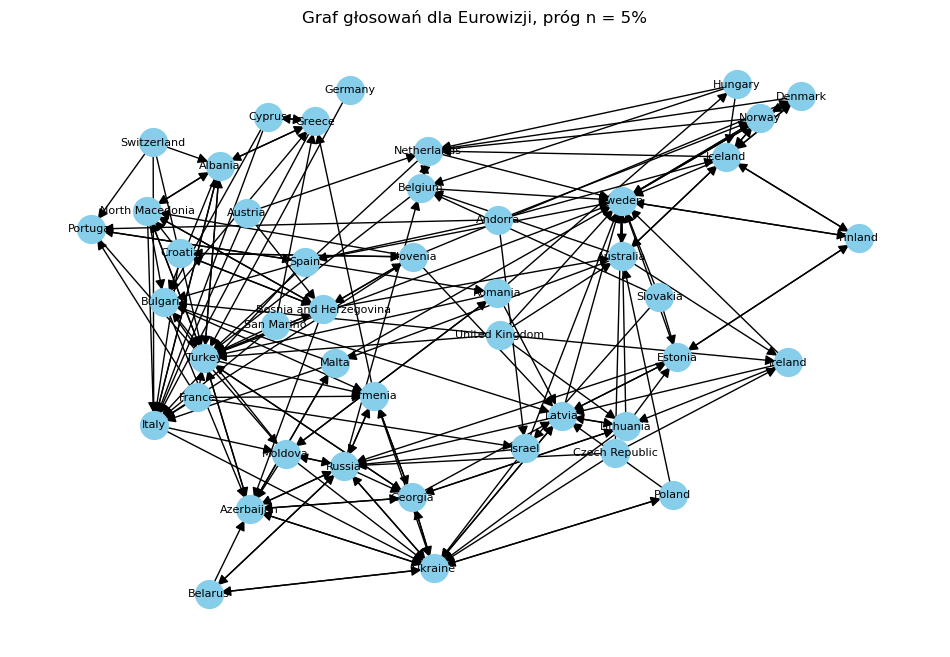

In [500]:
vizualize(avg[avg['significant_threshold_90']], title="Graf głosowań dla Eurowizji, próg n = 5%")

In [503]:
avg['significant_threshold_90'].value_counts()

significant_threshold_90
False    1710
True      190
Name: count, dtype: int64

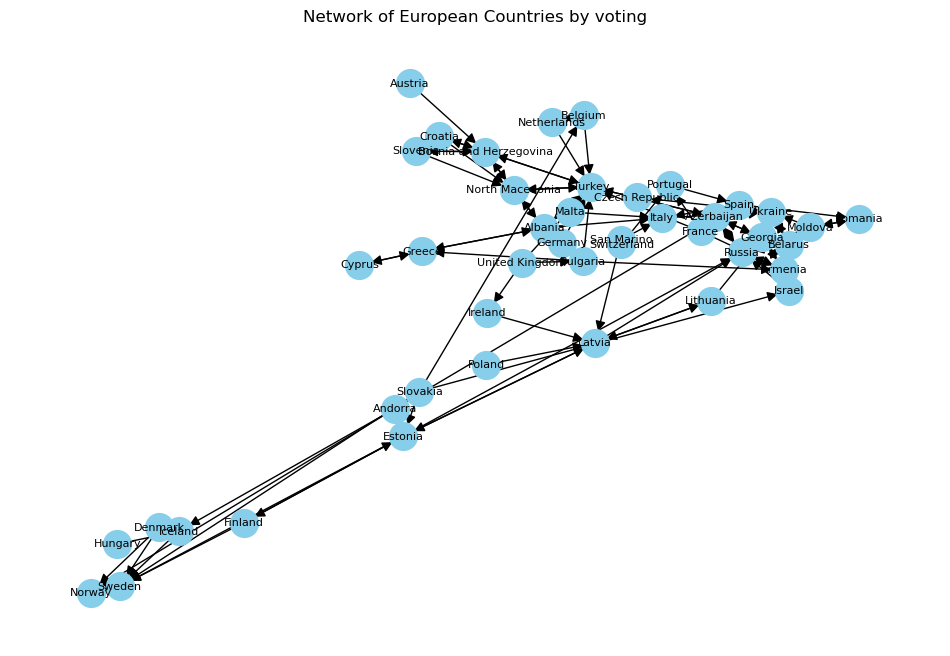

In [442]:
vizualize(avg[avg['significant_threshold_95']])

In [447]:
avg[f'significant_threshold_95'].value_counts()

significant_threshold_95
False    1805
True       95
Name: count, dtype: int64